In [86]:
#----------------standard packages------------------
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

#-----------------caio's modules---------------------
import sys, os #add code folder to sys.path
for folder in ['data_processing', 'data_wrangling', 'classification_models']:
    sys.path.append(os.path.abspath('../' + folder))

from player_model import player_model
from fe_model import fe_model
from data_wrangle import chrono_split_encode

from cricsheet_read import cricsheet_read #data processing

#---------------------load data----------------------
wrangle_data = pd.read_csv('../../data/fe_data.csv', dtype = {'match_id':str},
                           parse_dates = ['start_date']).set_index('match_id')

wrangle_data['start_date'] = wrangle_data['start_date'].dt.date

results = cricsheet_read()[1].drop('toss_winner', axis = 1)
results = results.join(pd.read_csv('../../data/betfair_data.csv',
                                   dtype = {'match_id':str}).set_index('match_id')).sort_index()

              precision    recall  f1-score   support

       False       0.56      0.68      0.61       411
        True       0.57      0.44      0.50       397

    accuracy                           0.56       808
   macro avg       0.57      0.56      0.56       808
weighted avg       0.57      0.56      0.56       808

chasing team always wins: roc auc = 0.500
model prediction: roc auc = 0.561


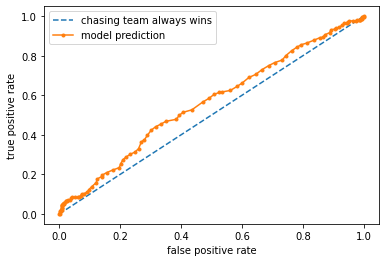

In [88]:
X_train, X_test, y_train, y_test = chrono_split_encode(wrangle_data, '2019-06-02', encode = False)
model, test_data = fe_model(X_train, X_test, y_train, y_test, results, algorithm = 'forest', metrics = True)

In [89]:
test_data = test_data.sort_values('start_date')
set_bet = (test_data['set_value'] > 0.3)*((test_data['set_team'] == test_data['result'])*(test_data['set_odds']) - 1)
chase_bet = (test_data['chase_value'] > 0.3)*((test_data['chase_team'] == test_data['result'])*(test_data['chase_odds']) - 1)

test_data['bet'] = (set_bet + chase_bet).cumsum()

test_data

,start_date,league,venue,match_name,set_team,chase_team,result,set_odds,chase_odds,set_prob,chase_prob,set_value,chase_value,bet
match_id,,,,,,,,,,,,,,
1188379,2019-06-23,T20 Internationals,Hazelaarweg,Netherlands v Zimbabwe,Netherlands,Zimbabwe,Netherlands,2.28,1.54,0.380,0.620,-0.1336,-0.04520,0.0
1168522,2019-07-14,T20 Internationals,Bready,Ireland v Zimbabwe,Ireland,Zimbabwe,Zimbabwe,2.26,1.79,0.465,0.535,0.0509,-0.04235,0.0
1167128,2019-07-18,Vitality Blast,Trent Bridge,Nottinghamshire v Worcestershire,Worcestershire,Nottinghamshire,Worcestershire,2.16,1.85,0.415,0.585,-0.1036,0.08225,0.0
1167144,2019-07-23,Vitality Blast,Kennington Oval,Surrey v Middlesex,Middlesex,Surrey,Middlesex,2.16,1.84,0.360,0.640,-0.2224,0.17760,0.0
1167143,2019-07-23,Vitality Blast,Grace Road,Leicestershire v Yorkshire,Yorkshire,Leicestershire,Yorkshire,1.51,2.78,0.530,0.470,-0.1997,0.30660,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1269670,2022-01-03,Big Bash League,Melbourne Cricket Ground,Melbourne Stars v Melbourne Renegades,Melbourne Stars,Melbourne Renegades,Melbourne Renegades,NaN,NaN,0.460,0.540,NaN,NaN,NaN
1269675,2022-01-04,Big Bash League,Carrara Oval,Perth Scorchers v Sydney Sixers,Perth Scorchers,Sydney Sixers,Perth Scorchers,NaN,NaN,0.310,0.690,NaN,NaN,NaN
1269672,2022-01-05,Big Bash League,Adelaide Oval,Hobart Hurricanes v Adelaide Strikers,Hobart Hurricanes,Adelaide Strikers,Adelaide Strikers,NaN,NaN,0.435,0.565,NaN,NaN,NaN


<AxesSubplot:xlabel='match_id'>

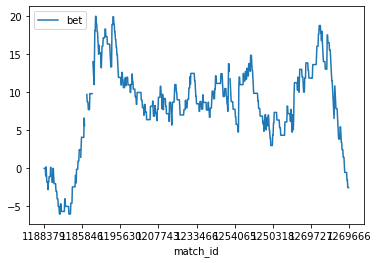

In [90]:
test_data.plot.line(y=['bet'])

In [91]:
set_bet.sum() + chase_bet.sum()

-2.539999999999999

In [92]:
chase_bet.sum()

-17.42

In [93]:
#-----------------caio's modules---------------------
import sys, os #add code folder to sys.path
sys.path.append(os.path.abspath('../archive'))

from backtest import backtest

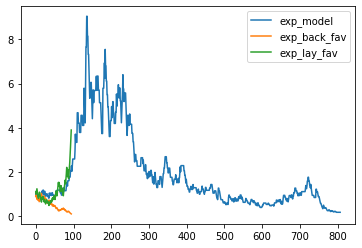

              exp_model  exp_back_fav  exp_lay_fav
return              NaN           NaN          NaN
t-confidence  45.493275           NaN          NaN


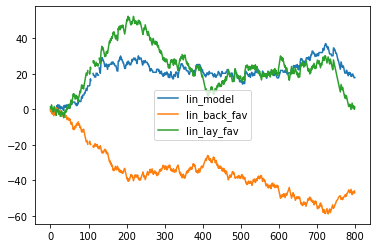

              lin_model  lin_back_fav  lin_lay_fav
return         4.268173     -5.807426     0.150198
t-confidence  74.507493      2.334822    51.377792


In [94]:
backtest(test_data, 0.2, 0.1)

In [ ]:
test_date = dt.datetime.strptime('2020-01-01', '%Y-%m-%d').date()
for match_date in results[results['start_date'] > test_date]

In [ ]:
bet = ((test_data['set_value'] > 0.2)*(test_data['set_team'] == test_data['result']) +
       
       
       
       
       
       (test_data['chase_value'] > 0.2)*(test_data['chase_team'] == test_data['result'])

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as scp
import Levenshtein

def backtest(data,betfair_data,lev_num=4):
    
    temp_data=data.copy()

    temp_data['set_team'] = temp_data['set_team'].str.replace(' ', '')
    temp_data['chase_team'] = temp_data['chase_team'].str.replace(' ', '')
    betfair_data['team_a'] = betfair_data['team_a'].str.replace(' ', '')
    betfair_data['team_b'] = betfair_data['team_b'].str.replace(' ', '')

    set_team_odds=[]
    chase_team_odds=[]
    
    for i in data.index:
    
        date=temp_data['date'][i]
        set_team=temp_data['set_team'][i]
        chase_team=temp_data['chase_team'][i]
        odds_data=betfair_data[betfair_data['date']==date]

        if odds_data[odds_data.apply(lambda x: Levenshtein.distance(x['team_a'],set_team), axis=1)<lev_num].size>0:
            set_team_odds.append(odds_data.loc[odds_data.apply(lambda x: Levenshtein.distance(x['team_a'],set_team), axis=1)<lev_num,'team_a_sp'].iloc[0])
            chase_team_odds.append(odds_data.loc[odds_data.apply(lambda x: Levenshtein.distance(x['team_b'],chase_team), axis=1)<lev_num,'team_b_sp'].iloc[0])

        elif odds_data[odds_data.apply(lambda x: Levenshtein.distance(x['team_a'],chase_team), axis=1)<lev_num].size>0:
            chase_team_odds.append(odds_data.loc[odds_data.apply(lambda x: Levenshtein.distance(x['team_a'],chase_team), axis=1)<lev_num,'team_a_sp'].iloc[0])
            set_team_odds.append(odds_data.loc[odds_data.apply(lambda x: Levenshtein.distance(x['team_b'],set_team), axis=1)<lev_num,'team_b_sp'].iloc[0])

    bt_df=data[['set_team_win','prob_set','prob_chase']].copy()
            
    bt_df['set_team_odds']=set_team_odds
    bt_df['chase_team_odds']=chase_team_odds   
    
#-------------------------------------------------backtest-------------------------------------------------------------
   
    ev_thresh=0
    commission=0.02
    
#------------------------------------------exponential backtest--------------------------------------------------------

    bankroll_init=1

    kelly_prop_set=(bt_df['set_team_odds']*bt_df['prob_set']-1)/(bt_df['set_team_odds']-1)
    kelly_prop_chase=(bt_df['chase_team_odds']*bt_df['prob_chase']-1)/(bt_df['chase_team_odds']-1)
    stake_prop=np.mean([item for item in [max(l1,l2) for l1,l2 in zip(kelly_prop_set,kelly_prop_chase)] if item > 0])

    bankroll=[[],[],[],[]]
    bet_result=[0,0,0]

    for i in bt_df.index:

#----------------------------------------------------model-------------------------------------------------

        if bt_df['set_team_odds'][i]*bt_df['prob_set'][i]-1>ev_thresh:
            bet_result[0]=bt_df['set_team_odds'][i]*bt_df['set_team_win'][i]*(1-commission)-1
            kelly_prop=kelly_prop_set[i]

        elif bt_df['chase_team_odds'][i]*bt_df['prob_chase'][i]-1>ev_thresh:
            bet_result[0]=bt_df['chase_team_odds'][i]*(1-bt_df['set_team_win'][i])*(1-commission)-1
            kelly_prop=kelly_prop_chase[i]

        else:
            bet_result[0]=0

#---------------------------------------------------back the favourite-------------------------------------    

        if bt_df['set_team_odds'][i]<bt_df['chase_team_odds'][i]:
            bet_result[1]=bt_df['set_team_odds'][i]*bt_df['set_team_win'][i]*(1-commission)-1

        else:
            bet_result[1]=bt_df['chase_team_odds'][i]*(1-bt_df['set_team_win'][i])*(1-commission)-1

#----------------------------------------------------lay the favourite--------------------------------------

        if bt_df['set_team_odds'][i]>bt_df['chase_team_odds'][i]:
            bet_result[2]=bt_df['set_team_odds'][i]*bt_df['set_team_win'][i]*(1-commission)-1

        else:
            bet_result[2]=bt_df['chase_team_odds'][i]*(1-bt_df['set_team_win'][i])*(1-commission)-1

#--------------------------------------------------bankroll calculations------------------------------------

        if i==0:
            bankroll[0].append(bankroll_init*(1+stake_prop*bet_result[0]))
            bankroll[3].append(bankroll_init*(1+kelly_prop*bet_result[0]))

            bankroll[1].append(bankroll_init*(1+stake_prop*bet_result[1]))
            bankroll[2].append(bankroll_init*(1+stake_prop*bet_result[2]))
        else:
            bankroll[0].append(bankroll[0][i-1]*(1+stake_prop*bet_result[0]))
            bankroll[3].append(bankroll[3][i-1]*(1+kelly_prop*bet_result[0]))

            bankroll[1].append(bankroll[1][i-1]*(1+stake_prop*bet_result[1]))
            bankroll[2].append(bankroll[2][i-1]*(1+stake_prop*bet_result[2]))

#-------------------------------------------------metrics------------------------------------------------------------        
    p_and_l=[[],[],[],[]]
    bet_returns=[0,0,0,0]
    confidence=[0,0,0,0]

    for i in [1,2]:
        bet_returns[i]=(bankroll[i][-1]-bankroll_init)/(sum(bankroll[i][:-1],bankroll_init)*stake_prop)*100

    bet_returns[0]=(bankroll[0][-1]-bankroll_init)/\
                   ((np.array([1]+bankroll[0][:-1])*\
                   np.ceil([max(l1,l2,0) for l1,l2 in zip(kelly_prop_set,kelly_prop_chase)])*stake_prop).sum())*100

    bet_returns[3]=(bankroll[3][-1]-bankroll_init)/\
                   ((np.array([1]+bankroll[3][:-1])*\
                   [max(l1,l2,0) for l1,l2 in zip(kelly_prop_set,kelly_prop_chase)]).sum())*100

    for i in range(len(bankroll)):

        p_and_l[i]=np.array(bankroll[i])
        p_and_l[i][1:] -= p_and_l[i][:-1]
        p_and_l[i]=[bet for bet in p_and_l[i] if bet != 0]

        confidence[i]=scp.t.cdf((bankroll[i][-1]-bankroll_init)/(np.sqrt(len(p_and_l[i]))*np.std(p_and_l[i],ddof=1)),\
                                len(p_and_l[i])-1)*100

#----------------------------------------------dataframe construction------------------------------------------------

    bt_metrics=pd.DataFrame.from_dict({'return':bet_returns,'t-confidence':confidence},orient='index',
                                     columns=['exp_model','exp_back_fav','exp_lay_fav','exp_model_kelly'])  

    bt_results=pd.DataFrame.from_dict({'exp_model':bankroll[0],'exp_back_fav':bankroll[1],
                                       'exp_lay_fav':bankroll[2],'exp_model_kelly':bankroll[3]})    

#----------------------------------------------linear backtest--------------------------------------------------------
    p_and_l=[[],[],[],[]]

    p_and_l[0]=(bt_df['set_team_odds']*bt_df['set_team_win']*(1-commission)-1)*\
                        (bt_df['set_team_odds']*bt_df['prob_set']-1>ev_thresh)+\
                        (bt_df['chase_team_odds']*(1-bt_df['set_team_win'])*(1-commission)-1)*\
                        (bt_df['chase_team_odds']*bt_df['prob_chase']-1>ev_thresh)

    p_and_l[1]=(bt_df['set_team_odds']*bt_df['set_team_win']*(1-commission)-1)*\
                            (bt_df['set_team_odds']<bt_df['chase_team_odds'])+\
                            (bt_df['chase_team_odds']*(1-bt_df['set_team_win'])*(1-commission)-1)*\
                            (bt_df['chase_team_odds']<=bt_df['set_team_odds'])

    p_and_l[2]=(bt_df['set_team_odds']*bt_df['set_team_win']*(1-commission)-1)*\
                            (bt_df['set_team_odds']>bt_df['chase_team_odds'])+\
                            (bt_df['chase_team_odds']*(1-bt_df['set_team_win'])*(1-commission)-1)*\
                            (bt_df['chase_team_odds']>=bt_df['set_team_odds'])

    bt_results['lin_model']=p_and_l[0].cumsum()
    bt_results['lin_back_fav']=p_and_l[1].cumsum()
    bt_results['lin_lay_fav']=p_and_l[2].cumsum()

#-----------------------------------------------------------metrics--------------------------------------------------  
    bet_returns=[0,0,0,0]
    confidence=[0,0,0,0]

    for i in range(3):
        bet_returns[i]=p_and_l[i].sum()/sum(p_and_l[i]!=0)*100

        confidence[i]=scp.t.cdf(p_and_l[i].sum()/(np.sqrt(len(p_and_l[i]))*np.std(p_and_l[i],ddof=1)),\
                                len(p_and_l[i])-1)*100

    bt_metrics['lin_model']=[bet_returns[0],confidence[0]]
    bt_metrics['lin_back_fav']=[bet_returns[1],confidence[1]]
    bt_metrics['lin_lay_fav']= [bet_returns[2],confidence[2]]   

#-----------------------------------------------------------charts--------------------------------------------------     

    bt_results.plot.line(y=['exp_model','exp_back_fav','exp_lay_fav','exp_model_kelly'])
    plt.show()
    print(bt_metrics[['exp_model','exp_back_fav','exp_lay_fav','exp_model_kelly']])
    
    bt_results.plot.line(y=['lin_model','lin_back_fav','lin_lay_fav'])
    plt.show()
    print(bt_metrics[['lin_model','lin_back_fav','lin_lay_fav']])

    return None
